In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
file = 'outputs/pred_matchday_9.xlsx'

In [3]:
db = pd.read_excel(file, index_col = 0)
my_team = pd.read_excel(file, sheet_name="my_teams", index_col=0, skiprows=[1])
my_team = my_team.loc[:, ~my_team.columns.str.contains('^Unnamed')].drop(columns="Lineup")
my_team

,role,team,oppteam,home,MV,FV,Potential,Clean Sheet %,starter,vote%
Players,,,,,,,,,,
Maignan,P,Milan,Juventus,1,6.156927,4.919640,3.568226,20.372452,0.00,0
Skorupski,P,Bologna,Frosinone,1,6.091409,5.593353,4.330683,55.562401,1.00,90
Sportiello,P,Milan,Juventus,1,6.192693,5.014385,3.586756,28.504366,1.00,90
Bellanova,D,Torino,Inter,1,5.512934,5.459619,6.616336,NaN,1.00,80
Birindelli,D,Monza,Roma,0,5.895388,5.877592,6.973133,NaN,0.35,60
Bradaric,D,Salernitana,Cagliari,1,5.909434,5.870750,6.715676,NaN,0.00,60
Danilo,D,Juventus,Milan,0,6.021709,6.182182,7.601590,NaN,1.00,90
Mancini,D,Roma,Monza,1,6.002866,6.150813,7.431929,NaN,1.00,90
Oyono,D,Frosinone,Bologna,0,5.868363,5.826803,6.355924,NaN,1.00,90


In [4]:
db

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Rossi F.,P,Atalanta,Genoa,1,0.00,1,6.158774,0.418705,5.687674,0.646104,6.080622,0.472741,0.122245,1.172330,6.439683,0.612129,-0.791301,1.185568,73.302686
Musso,P,Atalanta,Genoa,1,0.00,5,6.147611,0.407592,5.476502,0.625061,6.093825,0.470553,0.084676,1.174400,6.134711,0.679871,-0.653943,1.159810,62.036431
Carnesecchi,P,Atalanta,Genoa,1,1.00,70,6.141668,0.469838,4.969378,0.695534,6.001123,0.502854,0.205371,1.163731,5.234192,1.024465,-0.189714,0.993533,19.903097
Ruggeri,D,Atalanta,Genoa,1,1.00,80,6.134632,0.599844,6.555261,0.959377,6.167854,0.701058,-0.034756,0.798505,5.835031,1.274254,0.402130,1.299910,0.000000
Zortea,D,Atalanta,Genoa,1,0.00,30,6.085922,0.503924,6.478921,0.869387,6.018680,0.572512,0.086233,0.855754,5.769274,1.106315,0.451131,1.299912,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cruz,A,Verona,Napoli,1,0.00,30,5.869537,0.487927,6.006875,0.646208,5.847180,0.566018,0.029060,0.894900,5.646402,0.946820,0.277327,1.299884,0.000000
Henry,A,Verona,Napoli,1,0.00,30,5.818707,0.459089,5.974049,0.594923,5.663995,0.493161,0.229238,0.899311,5.521938,0.785709,0.408778,1.299892,0.000000
Kallon,A,Verona,Napoli,1,0.00,0,5.780354,0.385211,5.930166,0.491580,5.632517,0.403501,0.267233,0.970377,5.528056,0.624788,0.452486,1.299898,0.000000


In [5]:
def get_player_distributions(player): 
    dist_mv = tfp.distributions.SinhArcsinh(
    db.loc[player, 'MV loc'],
    db.loc[player, 'MV scale'],
    db.loc[player, 'MV skewness'],
    db.loc[player, 'MV tailweight']
    )
    
    dist_fv = tfp.distributions.SinhArcsinh(
    db.loc[player, 'FV loc'],
    db.loc[player, 'FV scale'],
    db.loc[player, 'FV skewness'],
    db.loc[player, 'FV tailweight']
    )
    
    dist_cs = tfp.distributions.Bernoulli(probs = db.loc[player, 'Clean Sheet %']/100)
    
    return [dist_mv, dist_fv, dist_cs];

In [6]:
def plot_simulation(squad_points_dist, total_points_mean, total_points_std, mod_points_mean, clean_sheets_mean):
    x = np.arange(start = 0, stop = 200, step = 0.001)
    prb = squad_points_dist.prob(x)

    mn = total_points_mean
    pot = mn + 2 * total_points_std

    f, ax = plt.subplots(1, 2)

    ax[0].plot(x, prb)
    ax[0].fill_between(x, prb, color = 'lightblue')
    ax[0].vlines(x = mn, color = 'black', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'mean = ' + "{:.2f}".format(mn))
    ax[0].vlines(x = pot, color = 'grey', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'potential = ' + "{:.2f}".format(pot))

    
    ax[0].set_xlim([40, 140])
    ax[0].set_ylim([0, 0.12])

    ax[0].legend()


    ax[1].text(0.1, 0.8, "\n".join(squad), fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

    text = "\n".join(['Avg Total Points = ' + "{:.2f}".format(total_points_mean), 
                        'Avg Mod Points = ' + "{:.2f}".format(mod_points_mean), 
                        'Avg Clean Sheets = ' + "{:.2f}".format(clean_sheets_mean)])

    ax[1].text(0.5, 0.8, text, fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

    ax[1].axis('off')


    plt.subplots_adjust(right=1.5)

    plt.show()

def simulate_lineup(squad, ITERS = 1000, MOD = False, mod_points_dict = None, CS = False, plot = True):
    dist = [None] * len(squad)

    defenders = list([0]) * len(squad)

    if mod_points_dict is None:
        mod_points_dict = {"high": 3, "medium": 2, "low": 1}

    for i in range(len(squad)):
        dist[i] = get_player_distributions(squad[i])  

        if(db['role'][squad[i]] == 'D'):
            defenders[i] = 1
            
    total_points = np.zeros(ITERS)
    clean_sheets = np.zeros(ITERS)
    mod_points = np.zeros(ITERS)

    mv_samples = [None] * len(squad)
    fv_samples = [None] * len(squad)

    for i in range(len(squad)):
        mv_samples[i] = dist[i][0].sample(ITERS)
        fv_samples[i] = dist[i][1].sample(ITERS)

    cs_samples = dist[0][2].sample(ITERS)

    for k in range(ITERS):
        d_points = list([0]) * len(squad)

        cleansheet = float(cs_samples[k])
        if(not CS):
            cleansheet = 0;
            
        total_points[k] += cleansheet
        clean_sheets[k] += cleansheet

        for i in range(len(squad)):
            if(db['role'][squad[i]] == 'P'):
                gk_points = float(mv_samples[i][k])

            if(defenders[i] == 1):
                d_points[i] = float(mv_samples[i][k])

            total_points[k] += float(fv_samples[i][k])

        d_points.sort(reverse = True)

        if(MOD and d_points[3] > 0): # minimum 3 defenders to get MOD
            mod_avg = 0
            for j in range(3):
                mod_avg += round(d_points[j] * 2) / 2
            mod_avg += round(gk_points * 2) / 2
            mod_avg /= 4

            if(mod_avg >= 7):
                mod_points[k] = mod_points_dict['high']
            elif(mod_avg >= 6.5):
                mod_points[k] = mod_points_dict['medium']
            elif(mod_avg >= 6):
                mod_points[k] = mod_points_dict['low']

        total_points[k] += mod_points[k]
    
    loc_0 = total_points.mean()

    squad_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(3),
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.SinhArcsinh(loc= loc_0 + t[..., 0], scale = 1e-3 + tf.math.softplus(t[..., 1]), 
                                                        skewness = t[..., 2], tailweight = 0.8) # fixed tailweight seems ok
            )
        ]
    )

    def negloglik(y, distr):
        return -distr.log_prob(y)

    squad_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1), loss=negloglik)

    dummy_input = np.zeros(total_points.shape)[:, np.newaxis]
    squad_model.fit(dummy_input, total_points, epochs=100, verbose=False)
    
    squad_points_dist = squad_model(np.zeros(1)[:, np.newaxis])

    if(plot):
        plot_simulation(squad_points_dist, total_points.mean(), total_points.std(), mod_points.mean(), clean_sheets.mean())
        
    return [squad_model, squad_points_dist, total_points.mean(), total_points.std(), mod_points.mean(), clean_sheets.mean()]

In [7]:
def sinh_archsinh_pdf(x, mu, sigma, eps, delta):
    mul = 2 / np.sinh( np.arcsinh(2) * delta)    
    z = (x - mu) / (sigma*mul)            
    S = np.sinh( -eps + (1/delta) * np.arcsinh(z))
    return np.exp(-0.5 * S * S) * np.sqrt(1 + S * S) / ( sigma * mul * delta ) / np.sqrt(1 + z * z) / np.sqrt(2 * np.pi)

def plot_lineup(squad, config):
    fig, axs = plt.subplots(6, 5, figsize=(14, 10))

    i = 0
    j = 1

    for ax in axs.flat:
        ax.axis('off')

        if(i < len(config) and config[i] == j):
            player = squad[i]

            mu = db.loc[player, 'FV loc']
            sigma = db.loc[player, 'FV scale']
            eps = db.loc[player, 'FV skewness']
            delta = db.loc[player, 'FV tailweight']

            x = np.arange(start = 0, stop = 30, step = 0.001)

            pxf = sinh_archsinh_pdf(x, mu, sigma, eps, delta)

            mf = np.average(x, weights = pxf)


            ax.plot(x, pxf, color = 'g', label = player)
            ax.fill_between(x, pxf, color = 'lightgreen')

            ax.vlines(x = mf, color = 'g', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'mfv = ' + '{:.2f}'.format(mf))    

            ax.legend(fontsize="9", loc ="upper right", handletextpad=0, handlelength=0)

            ax.axis(xmin = 0, xmax = 15, ymin = 0, ymax = 1)

            ax.axis('on')
            ax.get_yaxis().set_visible(False)

            ax.tick_params(axis='both', labelsize=7)

            i = i + 1

        j = j + 1
    

In [8]:
config_343 = [3, 7, 8, 9, 11, 15, 17, 19, 26, 28, 30];
config_352 = [3, 7, 8, 9, 16, 17, 18, 19, 20, 27, 29];
config_4231 = [3, 6, 7, 9, 10, 13, 17, 19, 21, 25, 28];
config_442 = [3, 6, 7, 9, 10, 17, 19, 21, 25, 27, 29];
config_433 = [3, 6, 7, 9, 10, 13, 17, 19, 26, 28, 30];
config_532 = [3, 6, 7, 8, 9, 10, 17, 18, 19, 27, 29];
config_541 = [3, 6, 7, 8, 9, 10, 17, 19, 21, 25, 28];
config_433_classic = [3, 6, 7, 9, 10, 17, 18, 19, 26, 28, 30];
config_343_classic = [3, 7, 8, 9, 16, 17, 19, 20, 26, 28, 30];

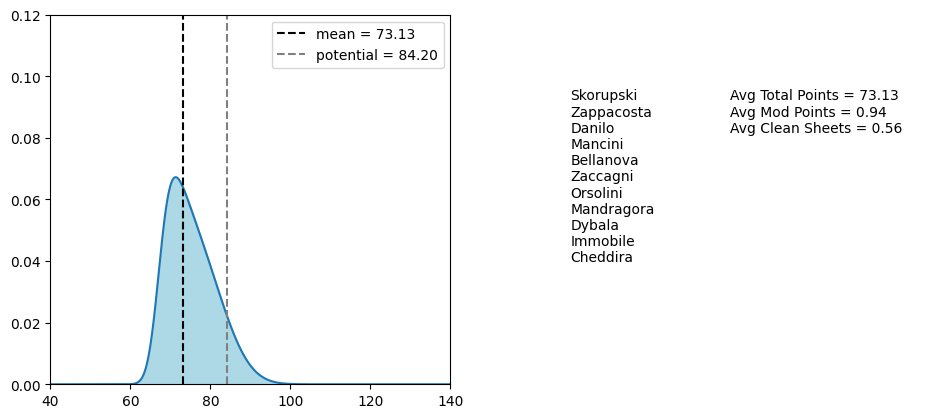

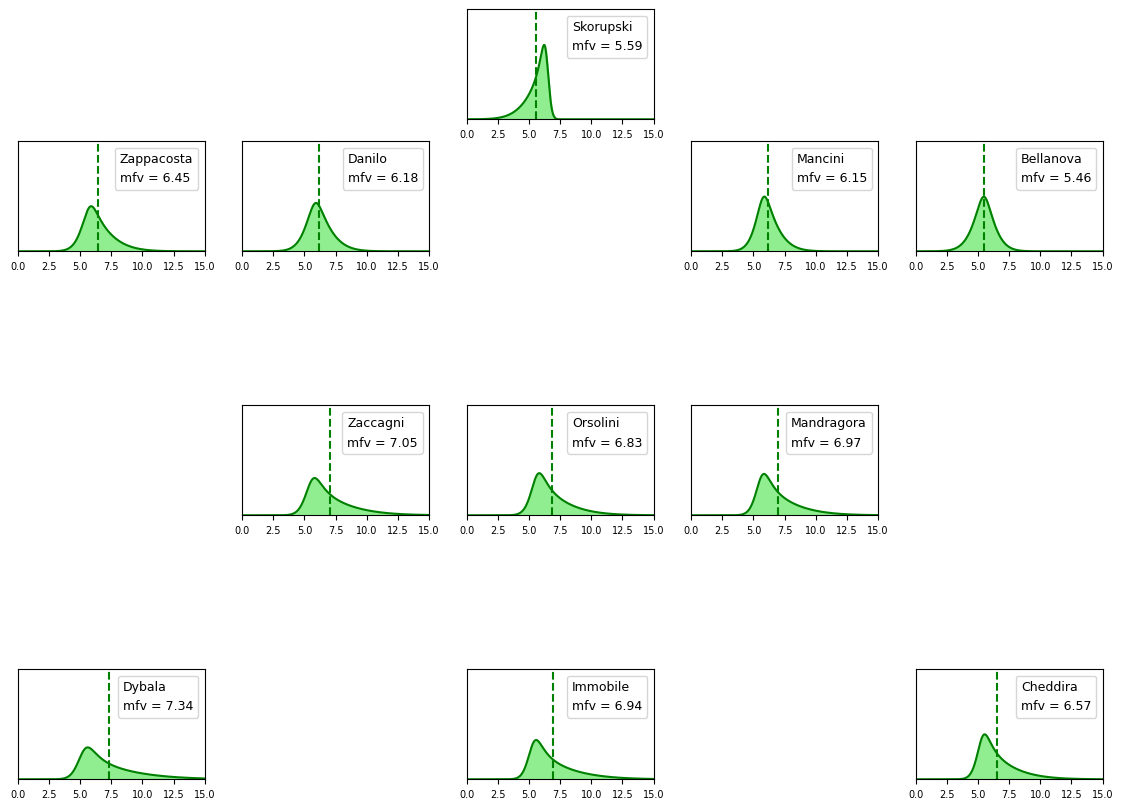

In [9]:
squad = ['Skorupski',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Bellanova',
        'Zaccagni',
        'Orsolini',
        'Mandragora',
        'Dybala',
        'Immobile',
        'Cheddira']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

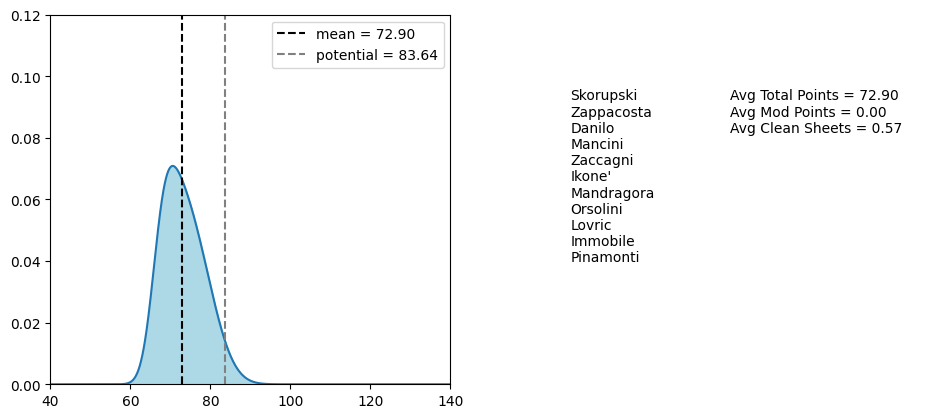

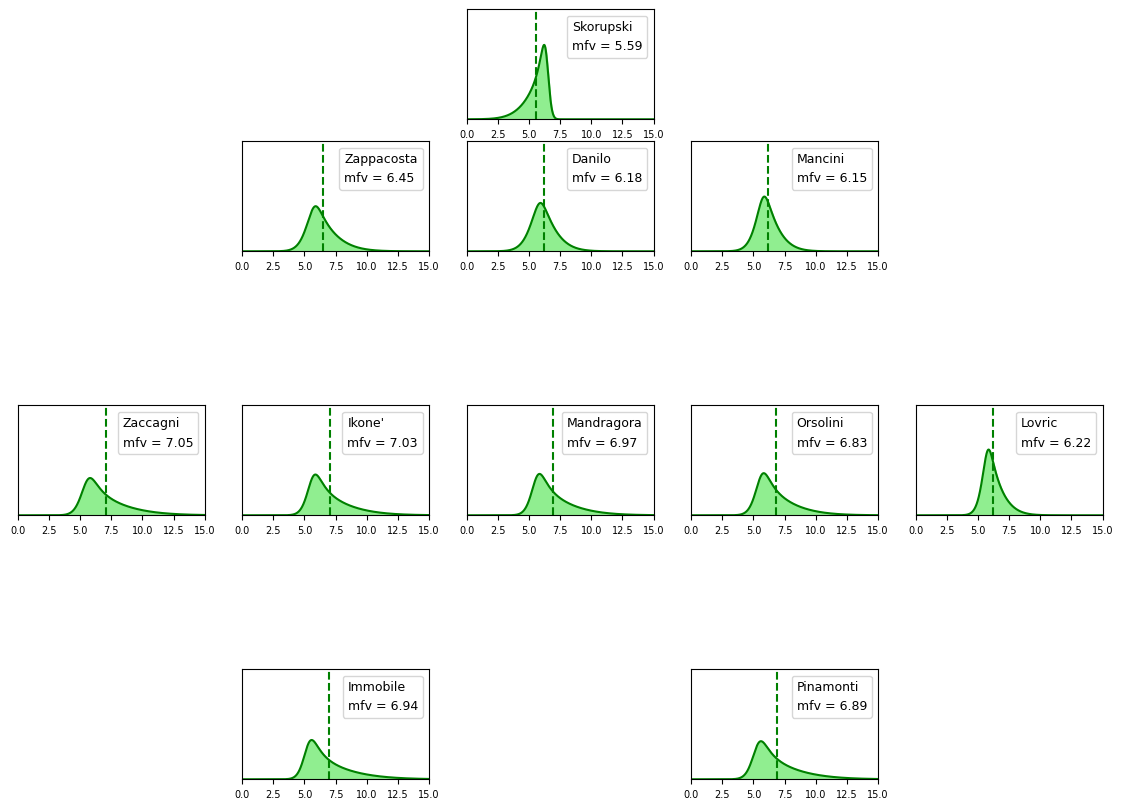

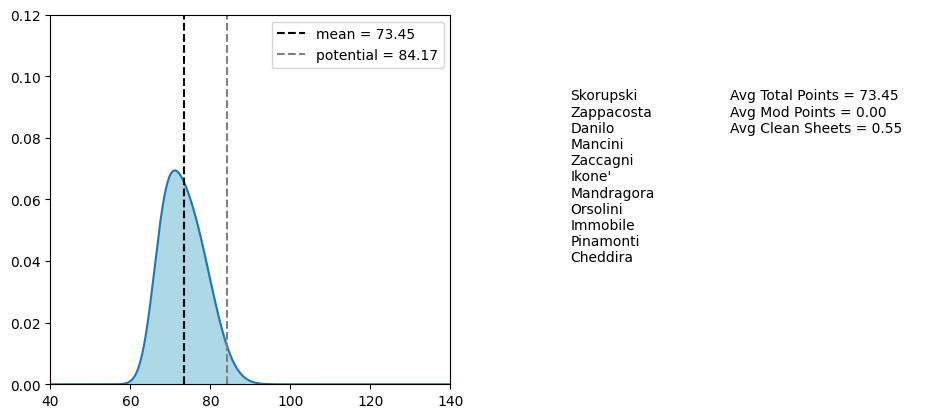

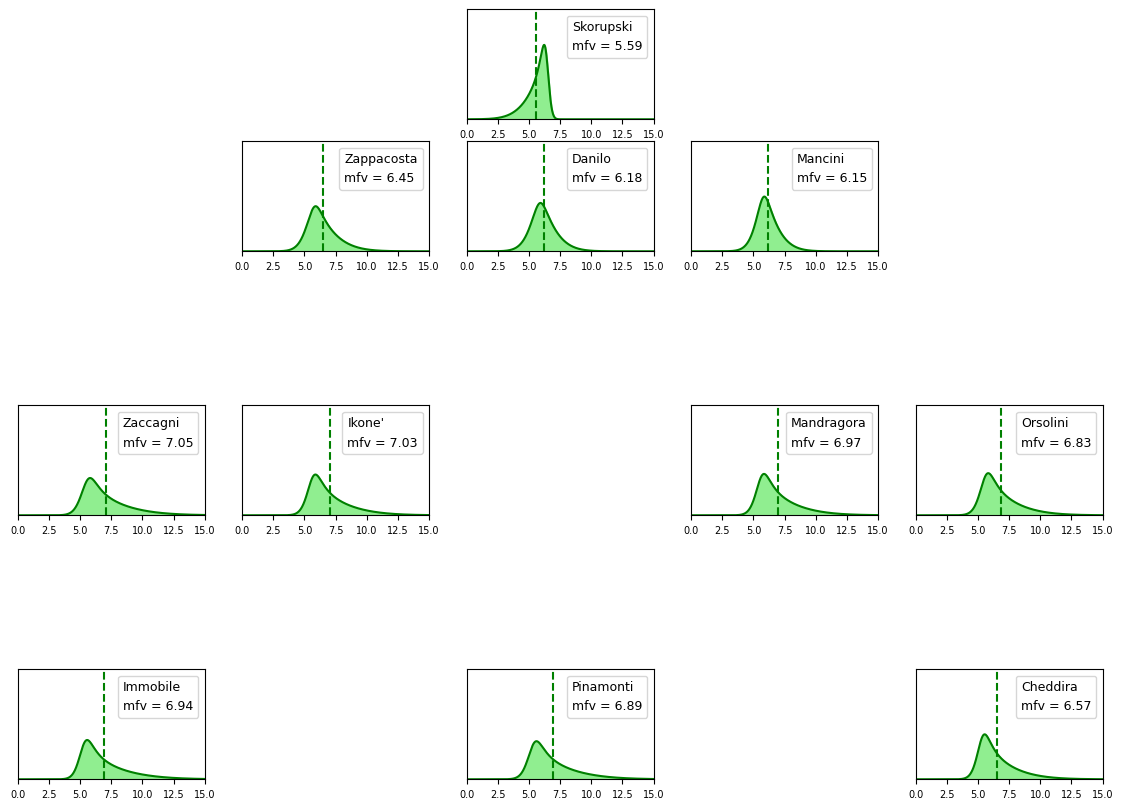

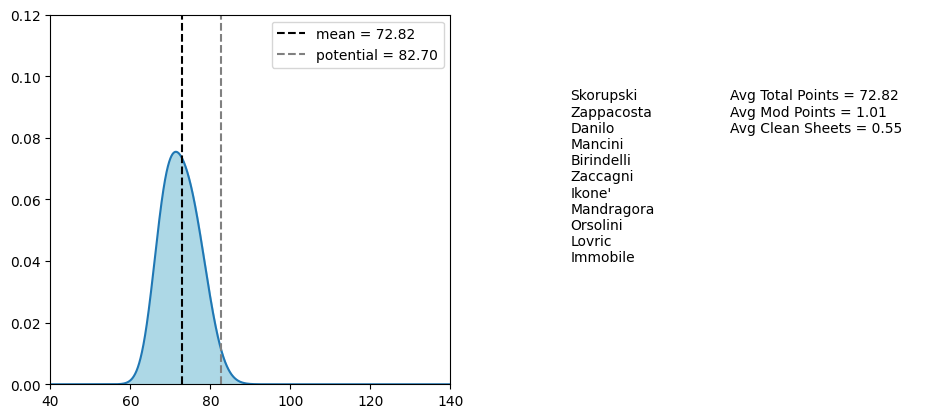

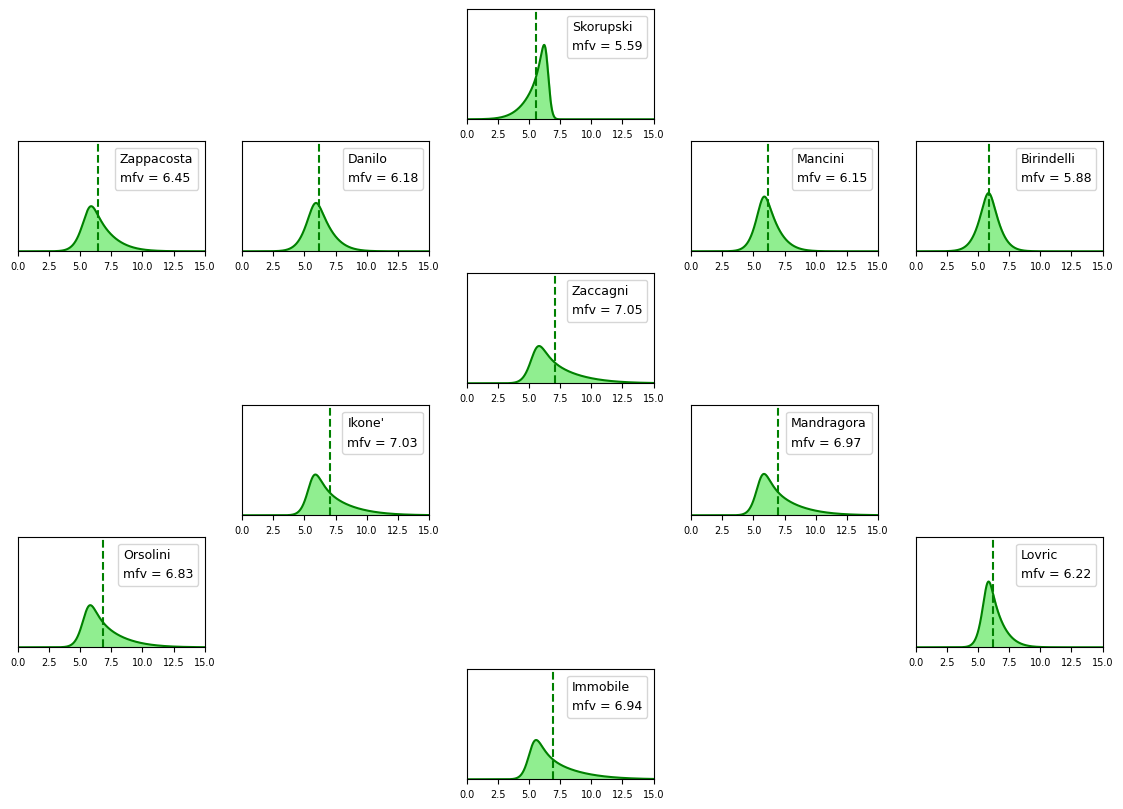

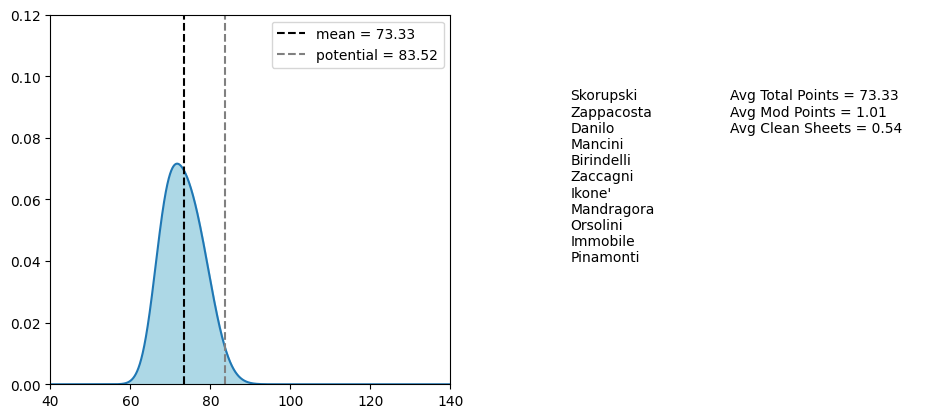

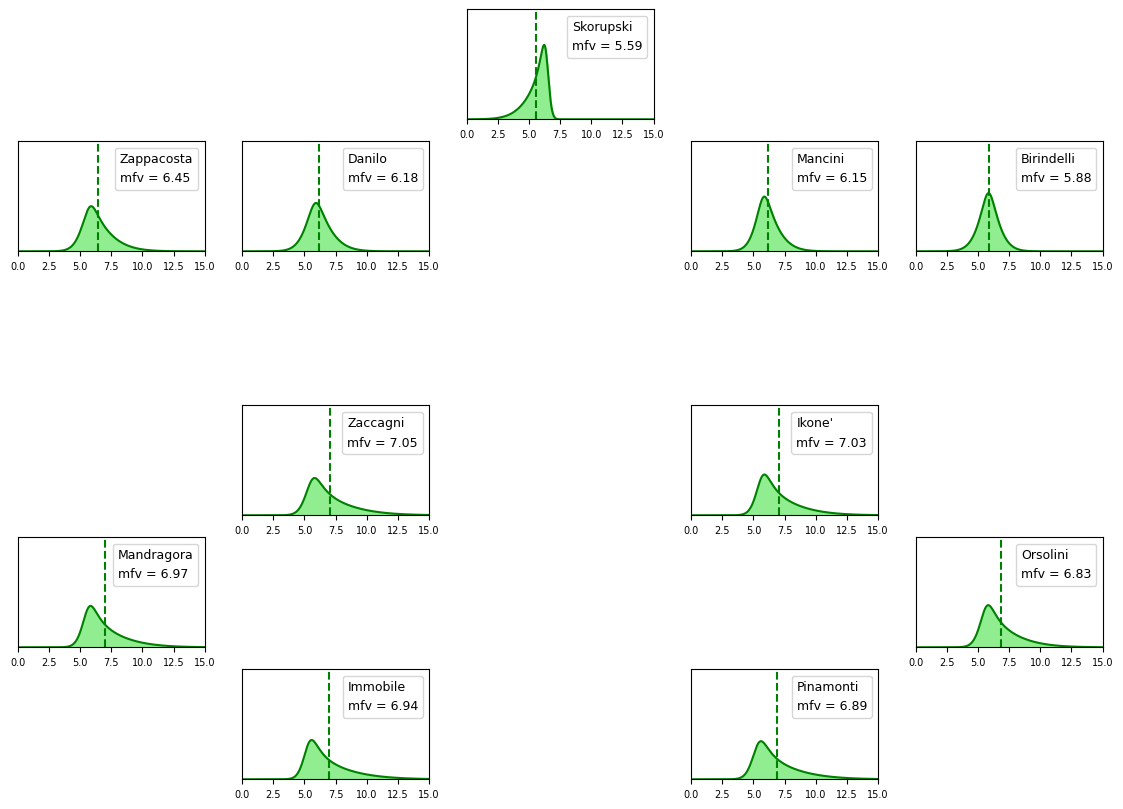

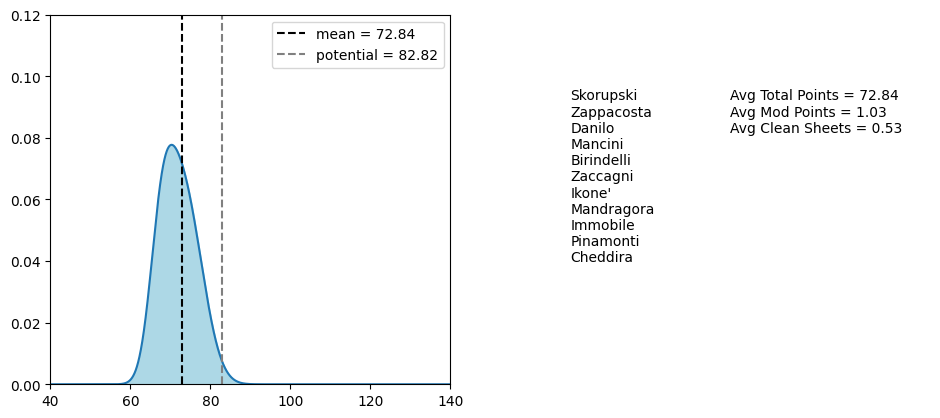

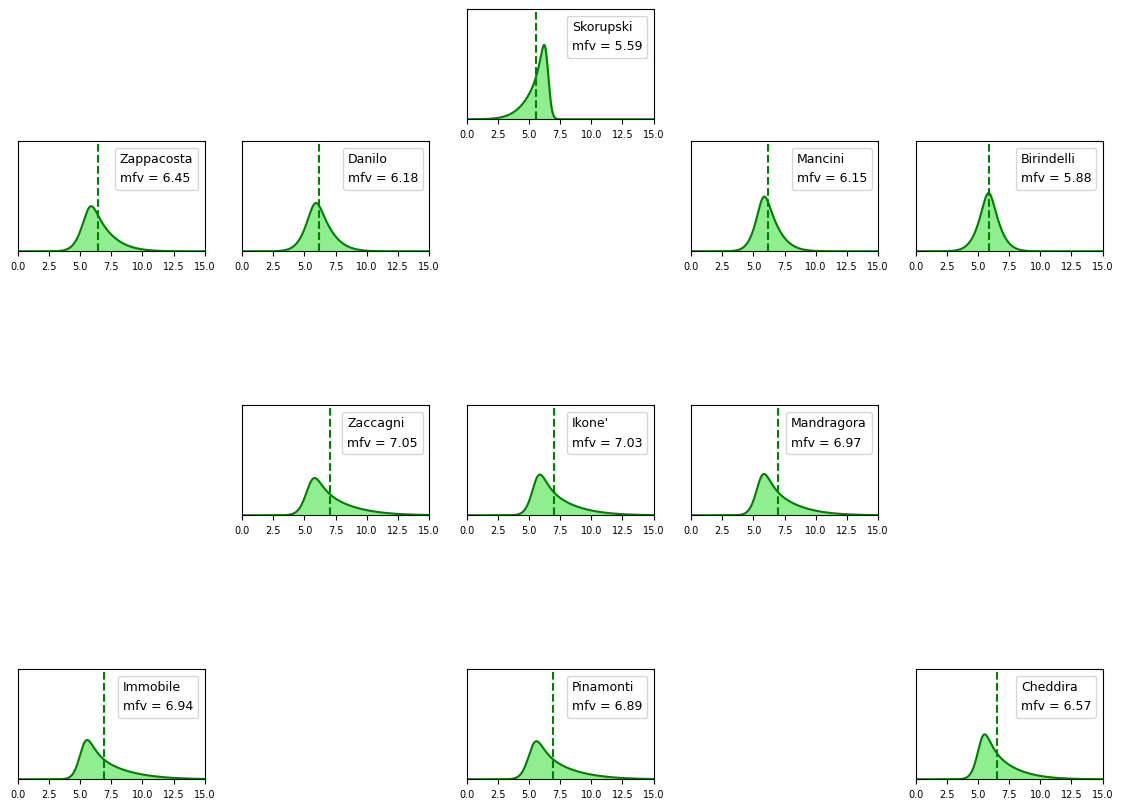

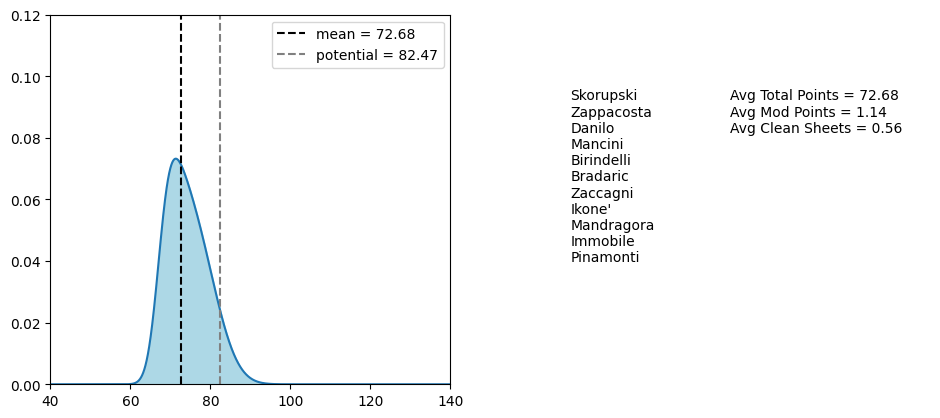

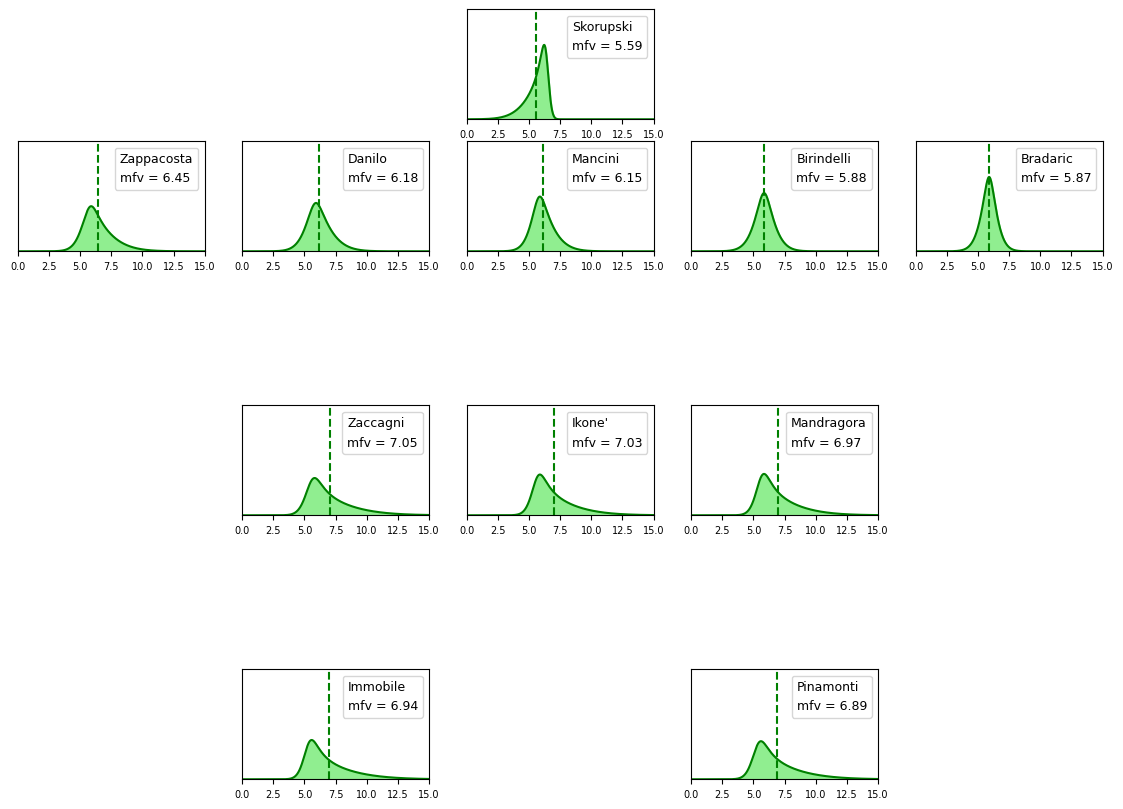

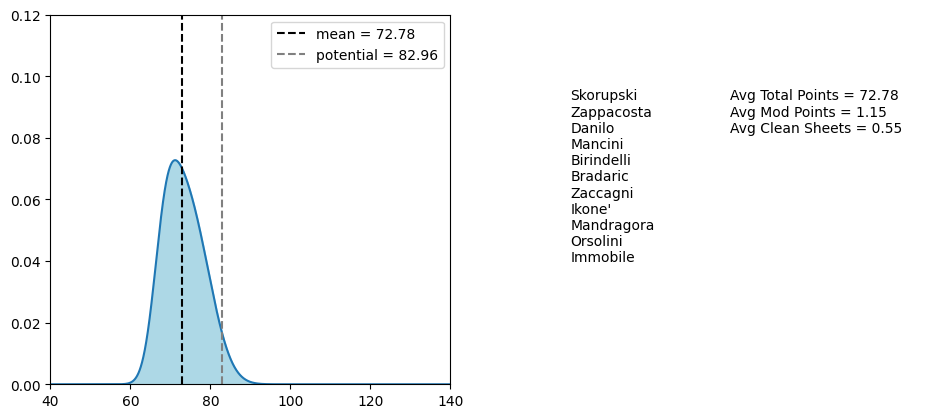

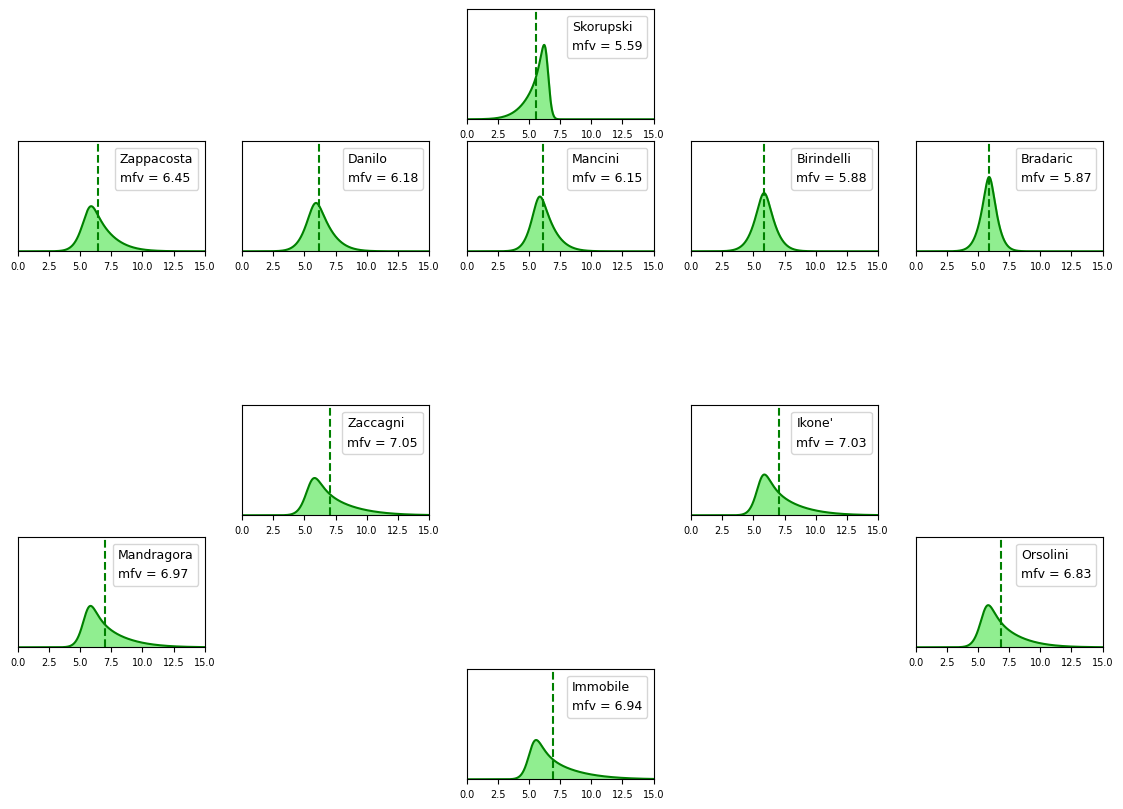

In [10]:
lineup_configs = ['352', '343', '451', '442', '433', '532', '541']
lineup_plot_configs = [config_352, config_343_classic, config_4231, config_442, config_433_classic, config_532, config_541]

def extract_players(lineup_config):
    n_defenders = int(lineup_config[0])
    n_midfielders = int(lineup_config[1])
    n_attackers = int(lineup_config[2])

    return n_defenders, n_midfielders, n_attackers

def best_lineup(lineup_config):
    n_def, n_mid, n_att = extract_players(lineup_config)

    my_team.sort_values(by="FV", ascending=False, inplace=True)

    best_gkp = my_team.query("role == 'P' and `vote%` >= 50").sort_values(by="Clean Sheet %", ascending=False).iloc[[0]]
    best_def = my_team.query("role == 'D' and `vote%` >= 50").iloc[0:n_def]
    best_mid = my_team.query("role == 'C' and `vote%` >= 50").iloc[0:n_mid]
    best_att = my_team.query("role == 'A' and `vote%` >= 50").iloc[0:n_att]

    return pd.concat([best_gkp, best_def, best_mid, best_att])


for idx, lineup_config in enumerate(lineup_configs):
    squad = best_lineup(lineup_config).index.tolist()
    s = simulate_lineup(squad, MOD = True, CS = True)
    plot_lineup(squad, lineup_plot_configs[idx])